# ECO491: Homework 3

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from arch import arch_model


## Question 1
See the answer in the attached written portion above

## Question 2

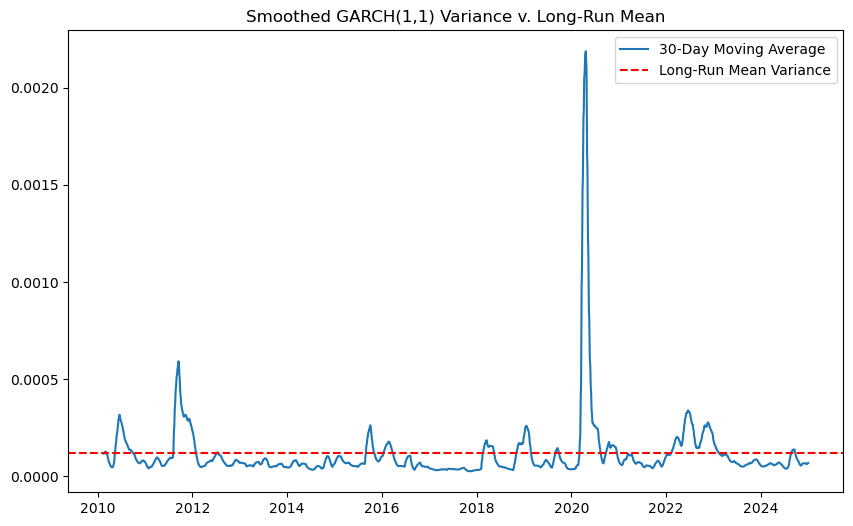

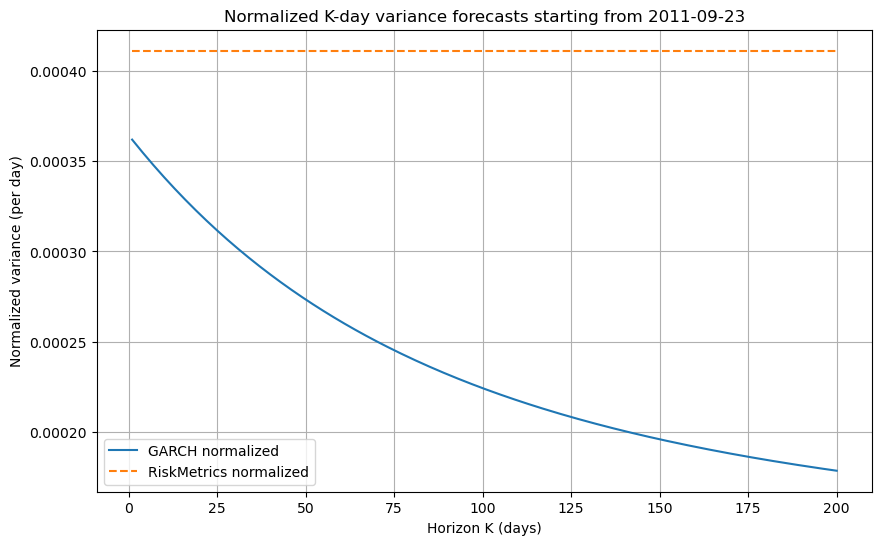

In [43]:
# Question 2 Coding Portion

df_returns = pd.read_excel("../data/SPY_2010_2024-2.xlsx")
df_returns = df_returns.set_index("Date")
df_log_returns = np.log(df_returns / df_returns.shift(1))
df_log_returns = df_log_returns.rename(columns={"Close Price": "Log Returns"})
df_log_returns = df_log_returns.dropna()


def k_cum_returns(df_log_returns: pd.DataFrame, k: int, t: int = 0):
    return df_log_returns["Log Returns"].iloc[t:t+k].sum()


model = arch_model(df_log_returns["Log Returns"], vol="GARCH", p=1, q=1, dist="normal", rescale=False)
res = model.fit(disp="off")

alpha = res.params["alpha[1]"]
beta = res.params["beta[1]"]
omega = res.params["omega"]

G_long = omega / (1 - alpha - beta)


df_log_returns["GARCH Variance"] = res.conditional_volatility**2
df_log_returns["GARCH 1-Day Variance Forecast"] = (
    omega + alpha * (df_log_returns["Log Returns"].shift(1))**2
    + beta * df_log_returns["GARCH Variance"].shift(1)
)


lam = 0.94
returns = df_log_returns["Log Returns"].fillna(0)
sigma2_rm = np.empty(len(returns))
sigma2_rm[:] = np.nan
sigma2_rm[0] = df_log_returns["GARCH Variance"].iloc[0]

for i in range(1, len(returns)):
    sigma2_rm[i] = lam * sigma2_rm[i-1] + (1 - lam) * (returns.iloc[i-1] ** 2)

df_log_returns["RM Variance"] = sigma2_rm
df_log_returns["RM 1-Day Forecast"] = (
    lam * df_log_returns["RM Variance"]
    + (1 - lam) * df_log_returns["Log Returns"]**2
)


nervous_days = df_log_returns[df_log_returns["GARCH 1-Day Variance Forecast"] > G_long]
t_nervous = nervous_days.index[150]  # choose a specific nervous day
sigma2_garch_t1 = df_log_returns.loc[t_nervous, "GARCH 1-Day Variance Forecast"]
sigma2_rm_t1    = df_log_returns.loc[t_nervous, "RM 1-Day Forecast"]


def garch_kday_cumulative(sigma2_t1, K, alpha, beta, omega):
    G_long = omega / (1 - alpha - beta)
    sig_h = np.empty(K)
    for h in range(1, K+1):
        sig_h[h-1] = G_long + (alpha + beta)**h * (sigma2_t1 - G_long)
    return np.cumsum(sig_h)


def riskmetrics_kday_cumulative(sigma2_t1, K):
    k = np.arange(1, K+1)
    return k * sigma2_t1


plt.figure(figsize=(10,6))
plt.plot(df_log_returns.index, df_log_returns["GARCH Variance"].rolling(30).mean(), label="30-Day Moving Average")
plt.axhline(G_long, color="red", linestyle="--", label="Long-Run Mean Variance")
plt.title("Smoothed GARCH(1,1) Variance v. Long-Run Mean")
plt.legend()
plt.show()


Kmax = 200
garch_cum = garch_kday_cumulative(sigma2_garch_t1, Kmax, alpha, beta, omega)
rm_cum    = riskmetrics_kday_cumulative(sigma2_rm_t1, Kmax)

k = np.arange(1, Kmax+1)
garch_norm = garch_cum / k
rm_norm    = rm_cum / k

plt.figure(figsize=(10,6))
plt.plot(k, garch_norm, label="GARCH normalized")
plt.plot(k, rm_norm, linestyle="--", label="RiskMetrics normalized")
plt.xlabel("Horizon K (days)")
plt.ylabel("Normalized variance (per day)")
plt.title(f"Normalized K-day variance forecasts starting from {t_nervous.date()}")
plt.legend()
plt.grid(True)
plt.show()

### Question 2 Written Portion

The RiskMetrics model shows very high persistence because it assumes volatility changes carry forward almost indefinitely. As a result, its forecasted variance grows steadily with the horizon and stays roughly constant when normalized. In contrast, the GARCH model allows volatility to mean revert toward a long-run level, so its forecasted variance flattens out over time. This means GARCH captures temporary spikes in volatility that gradually fade, while RiskMetrics keeps shocks alive much longer.

## Question 3
See the answer in the attached written portion above

## Question 4

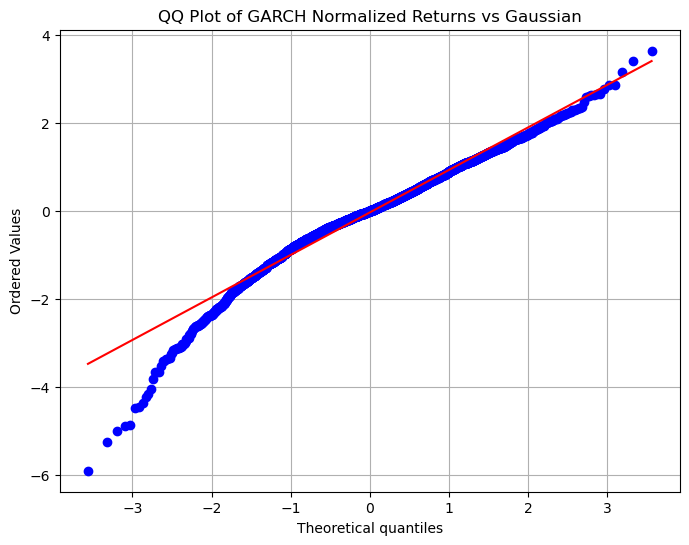

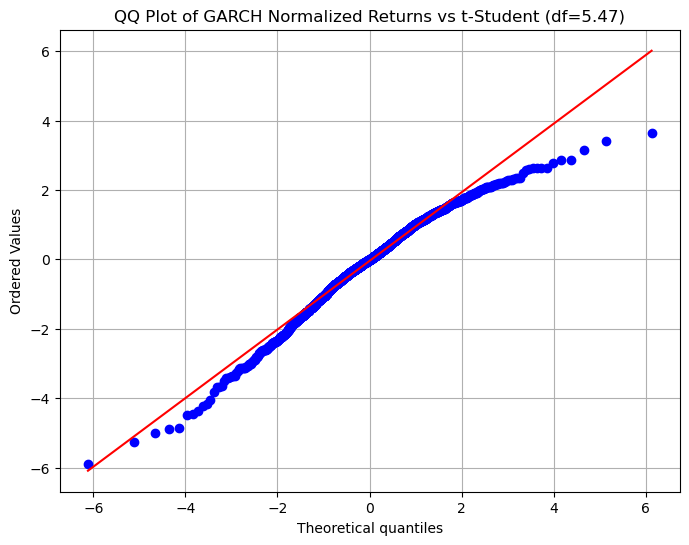

Estimated degrees of freedom (t-dist): 5.47


In [44]:
std_resid = res.std_resid.dropna()

plt.figure(figsize=(8,6))
stats.probplot(std_resid, dist="norm", plot=plt)
plt.title("QQ Plot of GARCH Normalized Returns vs Gaussian")
plt.grid(True)
plt.show()

params_t = stats.t.fit(std_resid)
df_t, loc_t, scale_t = params_t

plt.figure(figsize=(8,6))
stats.probplot(std_resid, dist=stats.t, sparams=(df_t, loc_t, scale_t), plot=plt)
plt.title(f"QQ Plot of GARCH Normalized Returns vs t-Student (df={df_t:.2f})")
plt.grid(True)
plt.show()

print("Estimated degrees of freedom (t-dist):", round(df_t, 2))


### Question 4 Written Portion

The QQ plots of GARCH-normalized returns against a Gaussian and t-distribution show fat tails that deviate from normality but align better with the t-student, suggesting that returns have heavier tails than Gaussian assumptions capture. Therefore, a t-student GARCH VaR would be preferred over a Gaussian GARCH VaR because it better accounts for extreme events and tail risk observed in the provided set of data.

### <u>*Statement of Collaboration (including ChatGPT)*</u>

I collaborated with **Linsey Zhong** and **Mark Rubin**. Additionally, **ChatGPT** was used to debug any error-prone code and assist with finding proper Python libraries, functions, parameters, etc.

### <u>*Honor Code*</u>
This assignment represents my own work in accordance with University regulations and class policy.